# Predicting Credit Card Defaults with `sklearn`

## Table of contents

- [Introduction](#1)
- [Data splitting](#2)
- [EDA](#3)
- [Feature engineering](#4)
- [Preprocessing and transformations](#5)
- [Baseline model](#6)
- [Linear models](#7)
- [Different classifiers](#8)
- [Feature selection](#9)
- [Hyperparameter optimization](#10)
- [Interpretation and feature importances](#11)
- [Results on the test set](#12)
- [Explaining predictions](#13)
- [Summary of the results](#14)

In [ ]:
# If you're missing a package, the following snippet may be of use!
import sys  
!{sys.executable} -m pip install --user pandas

## Imports 

In [1]:
import os

%matplotlib inline
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    plot_confusion_matrix,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC

from pandas_profiling import ProfileReport
from sklearn.tree import DecisionTreeClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.feature_selection import RFECV
import eli5
import shap

ModuleNotFoundError: No module named 'pandas'

## Introduction

**Problem**

The problem were given is one of binary classification. The goal is to, from an existing set of data about past credit card payments, predict whether or not a set of individuals will default on their next payment. The data set is available [here](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset).

**Columns**

Here's the definitions of each of the available columns, verbatim from [Kaggle](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). They're pasted here for ease-of-access. Additional comments and analysis are added as sub-points.

* `ID` ID of each client
    * This can serve as our index
* `LIMIT_BAL` Amount of given credit in NT dollars (includes individual and family/supplementary credit
* `SEX` Gender (1=male, 2=female)
    * It is probably worth dropping this feature; we don't want our model to predict based on sex as that's unethical
* `EDUCATION` (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
    * It turns out education also has 0; we'll want to consolidate 0, 5, and 6 to some common category
* `MARRIAGE` Marital status (1=married, 2=single, 3=others)
    * It turns out marriage also has a 0, so we'll put this in "others" as well
* `AGE` Age in years
* `PAY_0` Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)
    * There's a mistake in the original write-up; per [this comment](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset/discussion/34608) on Kaggle, there's also -2, which indicates "no consumption" and 0 which is use of revolving credit
    * This should definitely be named `PAY1` to be consistent with the other columns
* `PAY_2` Repayment status in August, 2005 (scale same as above)
    * Rename to `PAY2` to be consistent, etc.
* `PAY_3` Repayment status in July, 2005 (scale same as above)
* `PAY_4` Repayment status in June, 2005 (scale same as above)
* `PAY_5` Repayment status in May, 2005 (scale same as above)
* `PAY_6` Repayment status in April, 2005 (scale same as above)
* `BILL_AMT1` Amount of bill statement in September, 2005 (NT dollar)
* `BILL_AMT2` Amount of bill statement in August, 2005 (NT dollar)
* `BILL_AMT3` Amount of bill statement in July, 2005 (NT dollar)
* `BILL_AMT4` Amount of bill statement in June, 2005 (NT dollar)
* `BILL_AMT5` Amount of bill statement in May, 2005 (NT dollar)
* `BILL_AMT6` Amount of bill statement in April, 2005 (NT dollar)
* `PAY_AMT1` Amount of previous payment in September, 2005 (NT dollar)
* `PAY_AMT2` Amount of previous payment in August, 2005 (NT dollar)
* `PAY_AMT3` Amount of previous payment in July, 2005 (NT dollar)
* `PAY_AMT4` Amount of previous payment in June, 2005 (NT dollar)
* `PAY_AMT5` Amount of previous payment in May, 2005 (NT dollar)
* `PAY_AMT6` Amount of previous payment in April, 2005 (NT dollar)
* `default.payment.next.month` Default payment (1=yes, 0=no)
    * This will be our target

In [3]:
# Define a fixed random state to use for the entire notebook

RANDOM_STATE = 123
np.random.seed(RANDOM_STATE)
TODO = NotImplementedError()

In [4]:
# Read in the data set

file = "UCI_Credit_Card.csv"

# Read in df; treat column `ID` as index since it's unique
credit_df = pd.read_csv(f"./{file}", index_col=0)
credit_df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
2,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
3,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
4,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
5,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


**Wrangling**

Before we continue, let's do preliminary data wrangling. Note this is _before_ we split the data into train and test sets, but it should be okay to do despite without violating the Golden Rule meaningfully. We will

* rename the columns to be more consistent in formatting
* group undefined values from certain columns (e.g., value 0 is marriage is meaningless, so group with 3)

The undefined values were found from EDA on the training data; we went back and decided to remove them from the get-go, since that's a bit cleaner and does not impact the validity of our test score.

In [5]:
# Preliminary data wrangling

# Clean-up the column names
credit_df = credit_df.rename(columns={
    "PAY_0": "PAY1", 
    "PAY_2": "PAY2", 
    "PAY_3": "PAY3", 
    "PAY_4": "PAY4", 
    "PAY_5": "PAY5", 
    "PAY_6": "PAY6", 
    "default.payment.next.month": "DEFAULT" 
})


# Remove "bad" values from marriage, education (https://piazza.com/class/kt60nrdhu53454?cid=348)
# This was caught in EDA; we went back and removed it from ALL data (including test data)
credit_df["MARRIAGE"] = credit_df["MARRIAGE"].replace([0], 3)
credit_df["EDUCATION"] = credit_df["EDUCATION"].replace([0, 6], 5)

credit_df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY1,PAY2,PAY3,PAY4,PAY5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
ID,,,,,,,,,,,,,,,,,,,,,
1,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
2,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
3,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
4,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
5,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


## Data Splitting

Let's create our train and test splits, after reading in the data frame.

In [6]:
# See how many rows and columns are present in the original data to inform split

credit_df.shape

(30000, 24)

In [7]:
# Create X, y

target = "DEFAULT"
X = credit_df.drop(target, axis=1)
y = credit_df[target]

In [ ]:
# Split our data into a training set and a testing set

test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE)

display(X_train.head())
display(pd.DataFrame(y_train).head())

We're now finished creating the needed data frames for our analysis. In creating our model, we'll use only `X_train` and `y_train`. Once our final model is created, we'll score it again `X_test` and `y_test`.

## EDA

We'll now perform some preliminary exploration of the data.

In [9]:
# Let's begin by generating a profile report courtesy of pandas_profiling

profile = ProfileReport(X_train, minimal=True)
profile.to_widgets()

# Export summary to HTML file
profile.to_file("credit_df.html")

Summarize dataset:   0%|          | 0/32 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
# Generate basic summary statistics

X_train.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY1,PAY2,PAY3,PAY4,PAY5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.000000,22500.00000,22500.000000,...,22500.000000,22500.000000,22500.000000,22500.00000,22500.000000,2.250000e+04,22500.000000,22500.000000,22500.000000,22500.000000
mean,167912.608000,1.601689,1.852533,1.558400,35.477867,-0.017867,-0.137111,-0.172133,-0.22520,-0.265378,...,46961.377200,43389.790578,40363.350933,38763.81320,5673.348800,5.926811e+03,5287.000667,4785.724978,4806.159911,5261.697022
std,130144.258317,0.489561,0.784837,0.520791,9.206516,1.120041,1.195946,1.196880,1.16945,1.137946,...,68802.264441,64599.545694,61009.524485,59457.26977,16916.734372,2.151420e+04,18146.139695,15301.390285,15316.094460,18162.612241
min,10000.000000,1.000000,1.000000,1.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.00000,-2.000000,...,-157264.000000,-65167.000000,-61372.000000,-339603.00000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,...,2680.750000,2293.750000,1727.750000,1200.00000,1000.000000,8.240000e+02,390.000000,264.750000,234.000000,113.750000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,20089.000000,19067.500000,18043.500000,16855.00000,2100.000000,2.011000e+03,1812.000000,1500.000000,1500.000000,1500.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,60016.250000,54603.000000,50398.500000,49276.25000,5011.000000,5.000000e+03,4625.250000,4030.750000,4012.000000,4000.000000
max,1000000.000000,2.000000,5.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.00000,8.000000,...,855086.000000,891586.000000,927171.000000,961664.00000,873552.000000,1.227082e+06,896040.000000,621000.000000,426529.000000,528666.000000


In [11]:
# More summary statistics

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22500 entries, 16096 to 19967
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  22500 non-null  float64
 1   SEX        22500 non-null  int64  
 2   EDUCATION  22500 non-null  int64  
 3   MARRIAGE   22500 non-null  int64  
 4   AGE        22500 non-null  int64  
 5   PAY1       22500 non-null  int64  
 6   PAY2       22500 non-null  int64  
 7   PAY3       22500 non-null  int64  
 8   PAY4       22500 non-null  int64  
 9   PAY5       22500 non-null  int64  
 10  PAY6       22500 non-null  int64  
 11  BILL_AMT1  22500 non-null  float64
 12  BILL_AMT2  22500 non-null  float64
 13  BILL_AMT3  22500 non-null  float64
 14  BILL_AMT4  22500 non-null  float64
 15  BILL_AMT5  22500 non-null  float64
 16  BILL_AMT6  22500 non-null  float64
 17  PAY_AMT1   22500 non-null  float64
 18  PAY_AMT2   22500 non-null  float64
 19  PAY_AMT3   22500 non-null  float64
 20  PA

In [12]:
# Pertinent summary statistics
#  - The observation of the individual with the highest limit balance (#2198)

pd.DataFrame(X_train.loc[X_train["LIMIT_BAL"].idxmax()])

,2198
LIMIT_BAL,1000000.0
SEX,2.0
EDUCATION,1.0
MARRIAGE,1.0
AGE,47.0
PAY1,0.0
PAY2,0.0
PAY3,0.0
PAY4,-1.0
PAY5,0.0


In [13]:
#  - The average age
display(X_train["AGE"].mean())
display(X_train["AGE"].median())

35.477866666666664

34.0

In [14]:
# It might help to see value counts of MARRIAGE, EDUCATION, and PAY_1 to ensure the values that were missing from our legend are indeed gone

X_train["MARRIAGE"].value_counts()

2    12010
1    10213
3      277
Name: MARRIAGE, dtype: int64

In [15]:
X_train["EDUCATION"].value_counts()

2    10521
1     7955
3     3676
5      265
4       83
Name: EDUCATION, dtype: int64

In [16]:
X_train["PAY1"].value_counts()

 0    11065
-1     4313
 1     2755
-2     2036
 2     1980
 3      247
 4       55
 5       20
 8       12
 7        9
 6        8
Name: PAY1, dtype: int64

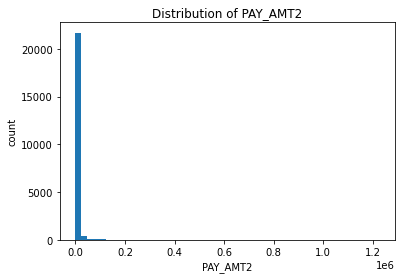

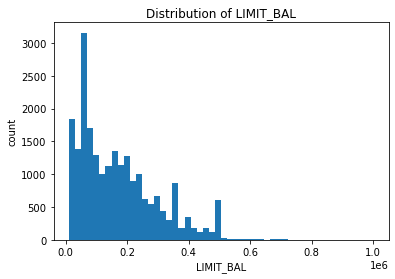

In [17]:
# Pertinent visualizations
#  - According to PandasProfilier, PAY_AMT2 is highly skewed; let's take a look!
#  - LIMIT_BAL is very pertinent to our analysis, so let's also understand it's distribution

# Code adapted from HW2
features = ["PAY_AMT2", "LIMIT_BAL"]

for feature in features:
    plt.hist(X_train[feature], alpha=1, bins=50)

    plt.xlabel(feature)
    plt.ylabel("count")
    plt.title(f"Distribution of {feature}")
    plt.show()

Let's also look at our class imbalance. Note the following plot does not have a title and is otherwise not well-formed, but what it represents should be fairly obvious despite. We're counting the number of "1"s and "0"s in our training data, to get a sense of any imbalance.

<AxesSubplot:>

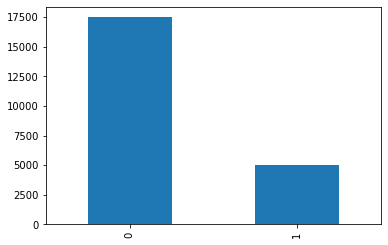

In [18]:
# It's definitely helpful to visualize our class imbalance as well

y_train.value_counts().plot(kind = "bar")

**Exploration**

We've now completed our exploration of this data set. In our exploration, we showed numerous summary statistics and visualized the distributions of two key features.

Looking at the customer with the highest credit, we can see repeatedly huge `BILL_AMT` values with correspondingly small `PAY_AMT`s. Our intuition tells us this kind of behaviour leads to a credit default. The average age in our data is ~35 and the median is 34. This gives us a rough sense of the age range we are working with; it seems most rows are "middle aged" individuals.

Our value counts show the undefined values from `MARRIAGE`, `EDUCATION` were successfully re-grouped as desired. Again, we did this _before_ splitting our data, but since it won't meaningfully impact our results, it's okay. Taking the step before the split greatly simplifies our code, which is valuable for code maintenance.

The distribution of `PAY_AMT2` is highly skewed, as suggested by `pandas_profiler`. It seems almost all values are 0 or close to 0 for this month. I wonder why bill repayments were so low in the month previous to August 2005? Perhaps some understanding of events within that time frame could help. The distribution for `LIMIT_BAL` is also skewed to the left, but less dramatically so. Most people have smaller balances. This seems reasonable given our intuition about wealth disparity in the 21st century.

Finally, we can see we have a bit of class imbalance in this dataset; there is an approximately 3-to-1 ratio of 0s to 1s, meaning there are many more examples of individuals not defaulting versus defaulting. This will motivate our chosen metric.

**Metrics**

The problem we're working with here is one of binary classification. This leads to a natural question—is accuracy the best metric?

To come at this question, we'll assume that the goal of this analysis is to predict when clients will default ahead of time, thus avoiding the default in the first place. Therefore, we want to minimize instances where we miss a default that would've occurred. (It should be safe to assume having extra "will-default" predictions is okay.)

Since "will-default" is our positive class, missing a "will-default" is considered a "false negative" (i.e., the absence of a condition when it is present). Given that we want to minimize false negatives, we should focus on the recall metric to see the best performance.

As a final caveat though, we'll be performing automatic hyperparameter optimization at numerous points in this analysis. Therefore, instead of letting various models automatically tune on recall, we'll take a more measured approach and use the F1-score instead. (Otherwise, we'll get an abysmal precision score; a harmonic mean is a better, more balanced approach.) This is also in lieu of an operating point, which would probably come from a hypothetical CEO or team lead.

## Feature Engineering

The goal is feature engineering is to use domain-specific knowledge, existing literature, and cross-validation to device more effective features for a given problem, that are of course not already present in the data set.

The paper linked at the start of the notebook evaluates a number of different "data mining techniques" for this binary classification problem. Crucially, in the paper, the authors _do not_ perform any form of feature engineering, so there's nothing we can directly mimic. However, he authors conclude that artificial neural networks (ANNs) outperform all other models, which is interesting, and can provides some benchmarks we can refer to later.

The question here does not specify how many features should be created nor how we should evaluate them. As a rough 'guess,' let's see if adding a feature that assesses the relative gap between the amount of the bill paid in one month and the amount of bill "generated" in one month.

Perhaps customers that have a consistently decreasing this gap are unlikely to default, and vice versa. We'd need to do a pairwise comparison between `BILL_AMT` and `PAY_AMT` for each month `1...6`. Our model, with only access to the absolute values, may miss out on the trends in the relative 'spacing' between these values.

We define a helper function that computes this column, and apply it to both data frames. Again, this is okay to do to `X_test` because it does not artificially enhance our test score in some way.

In [19]:
def relative(x1, x2):
    """
    Compute the relative difference between columns.
    """
    if x1 == 0 and x2 == 0:
        return 0 # 0% change
    if x1 == 0:
        return 1 # 100% change
    return abs(x2 - x1) / x1

In [20]:
# Visualize the newly added columns on train data
X_train_extended = X_train.copy()
X_test_extended = X_test.copy()

amts = [1, 2, 3, 4, 5, 6]
for amt in amts:
    X_train_extended.loc[:, f"BILL_PAY_RATIO{amt}"] = X_train_extended.apply(lambda row: relative(row[f"BILL_AMT{amt}"], row[f"PAY_AMT{amt}"]), axis = 1)
    X_test_extended.loc[:, f"BILL_PAY_RATIO{amt}"]  = X_test_extended.apply(lambda row: relative(row[f"BILL_AMT{amt}"], row[f"PAY_AMT{amt}"]), axis = 1)

X_train_extended[["BILL_PAY_RATIO1", "BILL_PAY_RATIO2", "BILL_PAY_RATIO3", "BILL_PAY_RATIO4", "BILL_PAY_RATIO5", "BILL_PAY_RATIO6"]].head()

,BILL_PAY_RATIO1,BILL_PAY_RATIO2,BILL_PAY_RATIO3,BILL_PAY_RATIO4,BILL_PAY_RATIO5,BILL_PAY_RATIO6
ID,,,,,,
16096,0.912427,1.000000,1.000000,0.949681,0.983683,10.213170
28549,0.976770,1.000000,0.000000,0.000000,0.000000,0.000000
25097,0.918516,0.970115,45.871795,0.842451,0.444444,1.000000
12261,0.946864,1.000000,0.910112,1.000000,1.000000,0.973799
21550,1.000000,-850.500000,1.000000,0.000000,1.000000,1.000000


## Preprocessing and transformations

We don't need to impute our data at all, we just need to encode or scale. The features `LIMIT_BAL`, `AGE`, `BILL_AMT1...6`, `PAY_AMT1...6`, and `BILL_PAY_RATIO1...6` should be scaled, as they are all numeric. Sex, education, marital status, and `PAY1...6` should all be encoded somehow. (Upon further reflection though, it's like more ethical to drop sex entirely.) We can almost apply an ordinal encoding to `education`, but the "others" category makes this impossible (could be more or less than what's given). We cannot apply an ordinal encoding to `PAY1...6` either since there is no way to rank some of the categories; we cannot tell whether value -2 (no consumption) is better or worse than value -1 (pay duly) or value 0 (use of rotating credit) or how these should compare with payment delay values 1 through 9. We will therefore apply a one-hot encoding to the all the categorical features.

We now define our column transformer.

In [21]:
feats = X_train_extended.columns.tolist() 

# Apply scaling to numeric features
numeric_feats = [
 'LIMIT_BAL',
 'AGE',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'BILL_PAY_RATIO1',
 'BILL_PAY_RATIO2',
 'BILL_PAY_RATIO3',
 'BILL_PAY_RATIO4',
 'BILL_PAY_RATIO5',
 'BILL_PAY_RATIO6'
]

# Apply a one-hot encoding
categorical_feats = [
 'EDUCATION',
 'MARRIAGE',
 'PAY1',
 'PAY2',
 'PAY3',
 'PAY4',
 'PAY5',
 'PAY6'
]

# Remove sex; unethical to consider
drop_feats = [
 'SEX',
]

assert(len(feats) == len(numeric_feats + categorical_feats + drop_feats))

In [22]:
ct = ColumnTransformer(
    [
        ("scaling", StandardScaler(), numeric_feats),
        ("onehot",  OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_feats),
        ("drop", "drop", drop_feats),
    ],
)

# ct

In [23]:
X_train_transformed = ct.fit_transform(X_train_extended)

In [24]:
column_names = (
    numeric_feats
    # Passing in categorical_feats gives our OHE nice names :-)
    + ct.named_transformers_["onehot"].get_feature_names(categorical_feats).tolist()
)

# column_names

In [25]:
pd.DataFrame(X_train_transformed, columns=column_names).head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,PAY6_-2,PAY6_-1,PAY6_0,PAY6_2,PAY6_3,PAY6_4,PAY6_5,PAY6_6,PAY6_7,PAY6_8
0,-0.214479,0.056715,0.113698,0.196343,0.210719,0.254004,0.342965,-0.510980,-0.027982,-0.275490,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.323397,-0.269149,-0.109391,-0.557621,-0.682571,-0.671688,-0.661606,-0.651975,-0.276262,-0.275490,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.136553,1.903274,-0.512158,-0.505997,-0.676902,-0.388708,-0.614399,-0.625065,-0.270055,-0.257362,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.598677,-1.355360,-0.183262,-0.144782,-0.132795,-0.047846,-0.020823,-0.010038,-0.217148,-0.275490,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-0.906035,-1.463981,-0.663274,-0.689493,-0.657905,-0.671688,-0.661606,-0.567879,-0.335376,-0.196517,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6. Baseline model <a name="6"></a>
<hr>

rubric={points:2}

**Your tasks:**
1. Try `scikit-learn`'s baseline model and report results.

In [26]:
# Adapted from CPSC 330, but modified to break mean, std into separate columns
def mean_std_cross_val_scores(model, X_train, y_train, name=None, raw=False, flatten=False, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas DataFrame with mean and std scores from cross_validation
    """
    # Could pass in cv as kwargs; defaults to 5
    # Always return train score
    kwargs["return_train_score"] = True
    
    scoring = [
        "accuracy",
        "f1",
        "recall",
    ]
    scores = cross_validate(model, X_train, y_train, scoring=scoring, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    
    mean_col = []
    std_col = []

    for mean, std in zip(mean_scores, std_scores):
        mean_col.append(float(f"%0.3f" % mean))
        std_col.append(float(f"%0.3f" % std))
    
    data = {}
    if flatten:
        # Having the data "flat" will be useful in hyperparameter tuning
        data = {
            "mean_fit_time"       : mean_col[0],
            "std_fit_time"        : std_col[0],
            "mean_score_time"     : mean_col[1],
            "std_score_time"      : std_col[1],
            "mean_test_accuracy"  : mean_col[2],
            "std_test_accuracy"   : std_col[2],
            "mean_train_accuracy" : mean_col[3],
            "std_train_accuracy"  : std_col[3],
            "mean_test_f1"        : mean_col[4],
            "std_test_f1"         : std_col[4],
            "mean_train_f1"       : mean_col[5],
            "std_train_f1"        : std_col[5],
            "mean_test_recall"    : mean_col[6],
            "std_test_recall"     : std_col[6],
            "mean_train_recall"   : mean_col[7],
            "std_train_recall"    : std_col[7],
        }
    else:
        # This is easier to read in a table
        data = {
            "mean": mean_col,
            "std" : std_col
        }
    
    if raw:
        # Don't convert to data frame
        return data
    else:
        return pd.DataFrame(data=data, index=[name or 0] if flatten else mean_scores.index)

In [27]:
def create_blank_data():
    """
    Create a starter frame for doing hyperparameter optimization.
    """
    return {
            "mean_fit_time"      : list(),
            "std_fit_time"       : list(),
            "mean_score_time"    : list(),
            "std_score_time"     : list(),
            "mean_test_accuracy" : list(),
            "std_test_accuracy"  : list(),
            "mean_train_accuracy": list(),
            "std_train_accuracy" : list(),
            "mean_test_f1"       : list(),
            "std_test_f1"        : list(),
            "mean_train_f1"      : list(),
            "std_train_f1"       : list(),
            "mean_test_recall"   : list(),
            "std_test_recall"    : list(),
            "mean_train_recall"  : list(),
            "std_train_recall"   : list(),
        }

In [28]:
dc = DummyClassifier()
pipe_dc = make_pipeline(ct, dc)

dc_results = mean_std_cross_val_scores(pipe_dc, X_train_extended, y_train)
dc_df = pd.DataFrame(dc_results)
display(dc_df)

,mean,std
fit_time,0.064,0.010
score_time,0.027,0.003
test_accuracy,0.777,0.000
train_accuracy,0.777,0.000
test_f1,0.000,0.000
train_f1,0.000,0.000
test_recall,0.000,0.000
train_recall,0.000,0.000


In [29]:
# Example of a flattened result dataframe
dc_results = mean_std_cross_val_scores(pipe_dc, X_train_extended, y_train, name="Default", flatten=True)
dc_df_flat = pd.DataFrame(dc_results)
display(dc_df_flat)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,mean_test_accuracy,std_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1,std_test_f1,mean_train_f1,std_train_f1,mean_test_recall,std_test_recall,mean_train_recall,std_train_recall
Default,0.074,0.009,0.03,0.002,0.777,0.0,0.777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


This will serve as our baseline for this prediction problem. Note this score reflects the class imbalance.

## Linear Models

Let's attempt to create linear-based classifiers, and see how they perform.

In [30]:
lr_scores_dict = {
    "C": 10.0 ** np.arange(-4, 6, 1),
} | create_blank_data()

for C in lr_scores_dict["C"]:
    # Create pipeline
    lr = LogisticRegression(C=C, max_iter=10000)
    pipe_lr = make_pipeline(ct, lr)
    
    lr_result = mean_std_cross_val_scores(pipe_lr, X_train_extended, y_train, name=f"C={C}", raw=True, flatten=True)
    for k, v in lr_result.items():
        lr_scores_dict[k].append(v)

In [31]:
lr_result_df = pd.DataFrame(data=lr_scores_dict)
lr_result_df

,C,mean_fit_time,std_fit_time,mean_score_time,std_score_time,mean_test_accuracy,std_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1,std_test_f1,mean_train_f1,std_train_f1,mean_test_recall,std_test_recall,mean_train_recall,std_train_recall
0,0.0001,0.084,0.011,0.019,0.001,0.777,0.000,0.777,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.0010,0.102,0.002,0.017,0.001,0.799,0.003,0.800,0.001,0.268,0.016,0.269,0.008,0.165,0.011,0.166,0.005
2,0.0100,0.187,0.019,0.019,0.002,0.815,0.003,0.816,0.001,0.426,0.013,0.431,0.009,0.309,0.012,0.312,0.009
3,0.1000,0.419,0.094,0.020,0.004,0.819,0.005,0.821,0.002,0.464,0.019,0.469,0.007,0.352,0.018,0.355,0.007
4,1.0000,0.681,0.046,0.019,0.003,0.819,0.005,0.822,0.002,0.465,0.019,0.472,0.006,0.352,0.018,0.358,0.006
5,10.0000,1.340,0.122,0.020,0.001,0.820,0.005,0.822,0.001,0.466,0.019,0.473,0.006,0.353,0.018,0.359,0.006
6,100.0000,2.352,0.343,0.020,0.001,0.820,0.005,0.822,0.001,0.465,0.020,0.473,0.006,0.353,0.019,0.358,0.006
7,1000.0000,3.305,0.563,0.020,0.001,0.820,0.005,0.822,0.001,0.465,0.020,0.473,0.006,0.353,0.019,0.358,0.006
8,10000.0000,2.932,1.028,0.021,0.002,0.820,0.005,0.822,0.001,0.466,0.020,0.473,0.006,0.353,0.019,0.358,0.006
9,100000.0000,3.599,0.923,0.020,0.002,0.820,0.005,0.822,0.001,0.465,0.020,0.473,0.006,0.353,0.019,0.359,0.006


The columns in the table we're most interested in are `mean_test_f1` and `mean_test_recall`. These are the validation scores we're interested in.

We see the scores plateau at about `C` equals 0.1 or 1; I'd probably lean to 0.1 since simpler models _generally_ are more effective on unseen data. This achieves a test accuracy of 0.819, a test F1 of 0.464, and a test recall of 0.352. Hopefully we can improve on these scores later on! 

## 8. Different classifiers <a name="8"></a>
<hr>
rubric={points:15}

**Your tasks:**
1. Try at least 3 other models aside from logistic regression. At least one of these models should be a tree-based ensemble model (e.g., lgbm, random forest, xgboost). 
2. Summarize your results. Can you beat logistic regression? 

### Decision Tree

For a first attempt, let's try a basic decision tree.

In [32]:
dt_scores_dict = {
    "max_depth": [1] + list(range(0, 50, 5))[1:] + [None],
} | create_blank_data()

for max_depth in dt_scores_dict["max_depth"]:
    # Create pipeline
    dt = DecisionTreeClassifier(max_depth=max_depth)
    pipe_dt = make_pipeline(ct, dt)
    
    dt_result = mean_std_cross_val_scores(pipe_dt, X_train_extended, y_train, name=f"max_depth={max_depth}", raw=True, flatten=True)
    for k, v in dt_result.items():
        dt_scores_dict[k].append(v)

In [33]:
dt_result_df = pd.DataFrame(data=dt_scores_dict)

# Clean-up NaN; convert to None as expected
dt_result_df.loc[[10], ["max_depth"]] = "None"

dt_result_df

,max_depth,mean_fit_time,std_fit_time,mean_score_time,std_score_time,mean_test_accuracy,std_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1,std_test_f1,mean_train_f1,std_train_f1,mean_test_recall,std_test_recall,mean_train_recall,std_train_recall
0,1.0,0.109,0.012,0.018,0.004,0.812,0.004,0.812,0.001,0.394,0.017,0.394,0.004,0.275,0.015,0.275,0.004
1,5.0,0.243,0.022,0.017,0.005,0.819,0.006,0.824,0.002,0.449,0.023,0.466,0.012,0.332,0.020,0.346,0.014
2,10.0,0.356,0.017,0.012,0.001,0.809,0.004,0.850,0.002,0.449,0.020,0.568,0.013,0.351,0.025,0.442,0.020
3,15.0,0.516,0.072,0.015,0.005,0.783,0.006,0.897,0.003,0.434,0.016,0.729,0.007,0.374,0.016,0.621,0.007
4,20.0,0.558,0.036,0.012,0.001,0.755,0.005,0.944,0.007,0.405,0.014,0.861,0.019,0.375,0.014,0.782,0.025
5,25.0,0.600,0.061,0.012,0.000,0.735,0.007,0.975,0.007,0.402,0.015,0.943,0.018,0.400,0.014,0.906,0.025
6,30.0,0.589,0.014,0.012,0.000,0.723,0.010,0.991,0.003,0.394,0.017,0.980,0.008,0.404,0.016,0.968,0.011
7,35.0,0.600,0.010,0.012,0.001,0.723,0.012,0.997,0.001,0.396,0.018,0.994,0.003,0.408,0.014,0.988,0.005
8,40.0,0.604,0.017,0.013,0.001,0.721,0.011,0.999,0.000,0.393,0.013,0.997,0.001,0.404,0.008,0.994,0.001
9,45.0,0.599,0.016,0.012,0.001,0.719,0.010,0.999,0.000,0.395,0.012,0.998,0.000,0.411,0.011,0.995,0.001


A bit shockingly, the shorter decision trees were very effective. A depth of 1 and 2 yielded test F1 scores of 0.449, which is nearly as good as our `LogisticRegression` model from the previous part. We also see a test recall score of 0.351 and a test accuracy of 0.809 for a `max_depth` equal to 2.

### Random Forest

For a second attempt, let's try a random forest. We won't tune the hyperparameters yet, because we'll do that in the next section!

In [34]:
rf_scores_dict = {
    "hps": ["Default"], # for RF, let's just leave the parameters as default for now
} | create_blank_data()

for hp in rf_scores_dict["hps"]:
    # Create pipeline
    rf = RandomForestClassifier()
    pipe_rf = make_pipeline(ct, rf)
    
    rf_result = mean_std_cross_val_scores(pipe_rf, X_train_extended, y_train, name=f"hp={hp}", raw=True, flatten=True)
    for k, v in rf_result.items():
        rf_scores_dict[k].append(v)

In [35]:
rf_result_df = pd.DataFrame(data=rf_scores_dict)
rf_result_df

,hps,mean_fit_time,std_fit_time,mean_score_time,std_score_time,mean_test_accuracy,std_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1,std_test_f1,mean_train_f1,std_train_f1,mean_test_recall,std_test_recall,mean_train_recall,std_train_recall
0,Default,3.966,0.342,0.106,0.005,0.815,0.006,0.999,0.0,0.47,0.018,0.998,0.0,0.368,0.017,0.997,0.001


Our forest is overfitting, but we haven't tuned yet. Our test accuracy was 0.815, test F1 was 0.47 (beating `LogisticRegression`), and our test recall was 0.368 (also winning out over `LogisticRegression`).

### LightGBM Classifier

Finally, let's try LightGBM. Again, no tuning.

In [36]:
lg_scores_dict = {
    "hps": ["Default"], # for LGBM, let's just leave the parameters as default for now
} | create_blank_data()

for hp in lg_scores_dict["hps"]:
    # Create pipeline
    lg = LGBMClassifier()
    pipe_lg = make_pipeline(ct, lg)
    
    lg_result = mean_std_cross_val_scores(pipe_lg, X_train_extended, y_train, name=f"hp={hp}", raw=True, flatten=True)
    for k, v in lg_result.items():
        lg_scores_dict[k].append(v)

In [37]:
lg_result_df = pd.DataFrame(data=lg_scores_dict)
lg_result_df

,hps,mean_fit_time,std_fit_time,mean_score_time,std_score_time,mean_test_accuracy,std_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1,std_test_f1,mean_train_f1,std_train_f1,mean_test_recall,std_test_recall,mean_train_recall,std_train_recall
0,Default,0.379,0.031,0.027,0.001,0.819,0.005,0.852,0.001,0.474,0.017,0.573,0.005,0.366,0.014,0.448,0.007


Our `LGBMClassifier` only did marginally better, but again, has yet to be tuned. Our test accuracy was 0.819, test F1 was 0.474, and test recall was 0.366.

### Summary

There are comments in each section reflecting on the individual scores. In sum, unsurprisingly, `RandomForestClassifier` and `LightGBM`, without any tuning, were able to beat our tuned `LogisticRegression` validation scores on the whole, especially with respect to our metric of interest, recall.

`LightGBM` and `RandomForestClassifier` were about on par with one another. We'll see if feature selection and additional tuning can improve either of these models in subsequent sections.

## Feature Selection

Let's arbitrarily choose `RandomForestClassifier` and run `RFECV` against it.

In [38]:
# Adapted from lecture code
rfe_pipe = make_pipeline(
    ct,
    # CV has to be 3 to complete in a reasonable amount of time on my device; ideally, this would be >=5
    RFECV(LogisticRegression(max_iter=2000), cv=3),
    RandomForestClassifier(),
)

rfe_result_df = mean_std_cross_val_scores(rfe_pipe, X_train_extended, y_train)

In [39]:
rfe_result_df

,mean,std
fit_time,80.762,5.863
score_time,0.113,0.031
test_accuracy,0.799,0.020
train_accuracy,0.903,0.076
test_f1,0.450,0.016
train_f1,0.730,0.228
test_recall,0.369,0.014
train_recall,0.656,0.274


There's no major improvement in this case using `RandomForestClassifier`, and given how expensive this operation is, we'll abandon it in the next exercises. (In fact, for this run, our F1 and accuracy scores were even worse, and our test recall value was higher by merely 0.001.) 

## Hyperparameter Optimization

We again, arbitrarily choose `RandomForestClassifier` and try to tune it's three major hyperparameters. `LightGBM` would've also been a very valid choice, but we don't have the computational ability to try both in a reasonable amount of time.

In this case, we also need to be particular about `scoring` being equal to `"f1"`, since the `RandomizedSearchCV` relies on it to determine the best score.

In [40]:
param_grid = {
    "randomforestclassifier__n_estimators": [1, 2, 5, 10, 25, 50, 100, 250],
    "randomforestclassifier__max_depth":    [1, 2, 5, 10, 25, 50, 100, 250],
    "randomforestclassifier__max_features": [1, 2, 5, 10, None]
}

pipe_rf = make_pipeline(ct, rf)

random_search = RandomizedSearchCV(pipe_rf, param_distributions=param_grid, scoring="f1", n_jobs=-1, n_iter=10, cv=5, refit=True, random_state=RANDOM_STATE)
random_search.fit(X_train_extended, y_train)

results = pd.DataFrame(random_search.cv_results_)
results.T

,0,1,2,3,4,5,6,7,8,9
mean_fit_time,0.535888,0.263791,2.624823,23.253887,1.801113,46.948318,0.463462,6.074613,5.906686,7.448897
std_fit_time,0.027816,0.013842,0.044188,0.502474,0.046059,4.444063,0.044263,0.356343,0.102688,1.363759
mean_score_time,0.065026,0.050925,0.198151,0.123644,0.070323,0.207921,0.070967,0.318962,0.400026,0.156888
std_score_time,0.002242,0.00282,0.00863,0.010522,0.002475,0.091048,0.014561,0.009017,0.011495,0.046151
param_randomforestclassifier__n_estimators,25,10,100,50,10,250,5,250,100,50
param_randomforestclassifier__max_features,5,2,2,None,10,None,1,10,1,10
param_randomforestclassifier__max_depth,1,1,5,5,25,2,25,1,25,250
params,"{'randomforestclassifier__n_estimators': 25, '...","{'randomforestclassifier__n_estimators': 10, '...","{'randomforestclassifier__n_estimators': 100, ...","{'randomforestclassifier__n_estimators': 50, '...","{'randomforestclassifier__n_estimators': 10, '...","{'randomforestclassifier__n_estimators': 250, ...","{'randomforestclassifier__n_estimators': 5, 'r...","{'randomforestclassifier__n_estimators': 250, ...","{'randomforestclassifier__n_estimators': 100, ...","{'randomforestclassifier__n_estimators': 50, '..."
split0_test_score,0.0,0.0,0.035122,0.446524,0.413393,0.386913,0.41826,0.0,0.404096,0.46183
split1_test_score,0.0,0.0,0.007952,0.442218,0.43608,0.380744,0.373868,0.0,0.413462,0.453674


In [41]:
random_search.best_params_

{'randomforestclassifier__n_estimators': 50,
 'randomforestclassifier__max_features': 10,
 'randomforestclassifier__max_depth': 250}

In [42]:
random_search.best_score_

0.46425316043454756

Our best performing parameters earned an F1-score of 0.461, which is close to the best score we've seen thus far, but still falls short of `LGBM`. The parameter used were `n_estimators=50`, `max_features=10`, and `max_depth=250`, so it created a rather complex forest. Something surprisingly, it's worse than our un-tuned random forest.

Since it stills falls short of `LGBM`'s performance, we'll return to `LGBM` in subsequent parts.

## Interpretation and feature importances

Here we arbitrarily jump back to `LGBM`, just to get more practice with different models, since just needed to choose "one of the best performing models."

In [43]:
# Let's go back to LGBM!

pipe_lgbm = make_pipeline(ct, LGBMClassifier())
pipe_lgbm.fit(X_train_extended, y_train)

eli5.explain_weights(
    pipe_lgbm.named_steps["lgbmclassifier"], feature_names=column_names
)

Weight,Feature
0.2675,PAY1_2
0.0928,PAY2_2
0.0518,PAY_AMT2
0.0431,LIMIT_BAL
0.0381,PAY_AMT1
0.0313,BILL_AMT1
0.0294,AGE
0.0284,PAY3_2
0.0261,BILL_PAY_RATIO1
0.0256,PAY_AMT3


We find `PAY1` to carry the most impact; since it was one-hot encoded, and in particular, when it took on a value of 2. Indeed, it seems "2" as a value for any of the `PAYX` features carried a significant amount of weight. This corresponds to a "payment delay [of] two months" which I find rather interesting; perhaps a domain-expert would be able to provide some insight of why 2 months in particular becomes unrecoverable, whereas presumably 1 month could be okay.

Looking at other meaningful columns, we see `PAY_AMT2` and `PAY_AMT1` ranking highly, which makes intuitive sense; if a customer is on track from the beginning, we'd expect them to stay on track until the end. On the other hand, starting on the wrong foot could have lasting consequences.

`AGE` is higher than I expected it to be; we can't know if this is a linear impact or not, but I'd expect it to be non-linear. It's like young people and old people are the most likely to default, with middle-aged folks who have stable jobs to be the least likely to default. This is all speculation, though.

Again, it's important to note this importances are unsigned and not necessarily linear, so we have to be careful in our interpretation of them. They're just "important somehow," and it's up to us to interpret in what direction (or, rely on SHAP force plots, as we do below).

## Performance

Let's see how our models do against our test data!

Our best model was `LGBMClassifier`, despite attempting to tune `RandomForestClassifier`. Let's now try it on the test set.

In [44]:
lg = LGBMClassifier()
pipe_lg = make_pipeline(ct, lg)

pipe_lg.fit(X_train_extended, y_train)

y_train_pred = pipe_lg.predict(X_train_extended)
print(classification_report(y_train, y_train_pred, target_names=["non-default", "default"]))

              precision    recall  f1-score   support

 non-default       0.86      0.96      0.91     17491
     default       0.77      0.43      0.55      5009

    accuracy                           0.84     22500
   macro avg       0.81      0.70      0.73     22500
weighted avg       0.84      0.84      0.83     22500



In [45]:
y_test_pred = pipe_lg.predict(X_test_extended)
print(classification_report(y_test, y_test_pred, target_names=["non-default", "default"]))

              precision    recall  f1-score   support

 non-default       0.85      0.94      0.89      5873
     default       0.65      0.38      0.48      1627

    accuracy                           0.82      7500
   macro avg       0.75      0.66      0.69      7500
weighted avg       0.80      0.82      0.80      7500



We find an F1-score of 0.48, an accuracy of 0.82, and a recall of 0.38. They're on par with our validation scores from earlier, though lower than I would've hoped. In particular, a 0.38 recall score is quite good, and our F1-score generalized well to the test set; our validation set score was 0.474. (So, surprisingly, our model did even better in testing than in validation!)

There was perhaps _opportunity_ for optimization bias here, but we don't think it occurred in our analysis. We did tune on hyperparameters, the number of features, and even the kind of model we're using (switching between `LGBM` and `RandomForestClassifier` in this case). Given how well our model generalized, I don't believe we in fact over-optimized for our hyperparameters; we would've seen a much worse F1-score if we had done so.

## Prediction Explanations

Using SHAP force plots, let's see why our predictions turned out the way they did.

In [46]:
shap.initjs()

In [47]:
X_train_enc = pd.DataFrame(
    data=ct.transform(X_train_extended),
    columns=column_names,
    index=X_train_extended.index,
)

X_train_enc.shape

(22500, 92)

In [48]:
X_test_enc = pd.DataFrame(
    data=ct.transform(X_test_extended),
    columns=column_names,
    index=X_test_extended.index,
)

X_test_enc.shape

(7500, 92)

In [49]:
# This cell takes a VERY LONG time to run (https://github.com/slundberg/shap/issues/2002)
# It may not be able to output plots in time for the HW submission; however, this is the general idea for SHAP force plots
# Limit to 100 values as a fix (https://github.com/slundberg/shap/issues/838)

lg_explainer = shap.TreeExplainer(pipe_lg.named_steps["lgbmclassifier"])
train_lgbm_shap_values = lg_explainer.shap_values(X_train_enc[:100])
test_lgbm_shap_values  = lg_explainer.shap_values(X_test_enc[:100])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [50]:
# Sample values to test
y_test_reset = y_test.reset_index(drop=True)

ind_0 = y_test_reset[y_test_reset == 0].index.tolist()
ind_1 = y_test_reset[y_test_reset == 1].index.tolist()

sample_ind_0 = ind_0[10]
sample_ind_1 = ind_1[10]

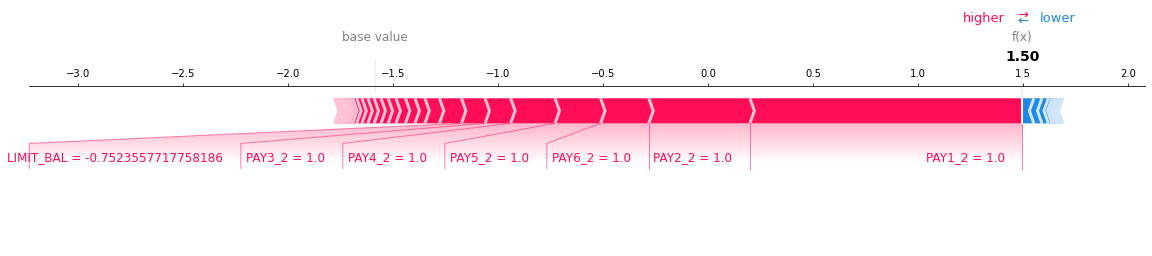

In [51]:
# Try an example on X_train
shap.force_plot(
    lg_explainer.expected_value[1],
    train_lgbm_shap_values[1][sample_ind_1, :],
    X_train_enc.iloc[sample_ind_1, :],
    matplotlib=True,
)

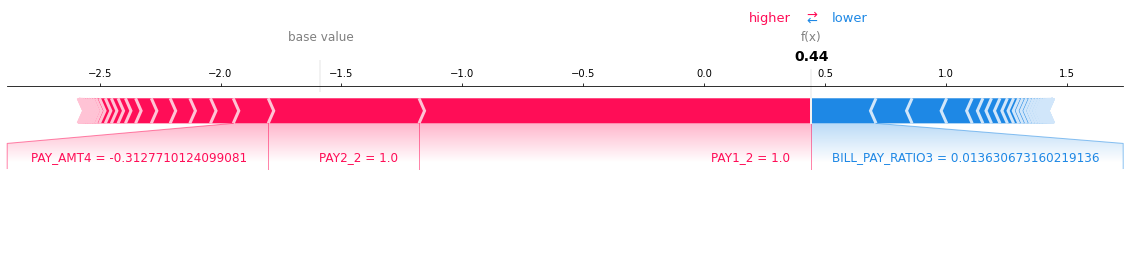

In [52]:
# Try an example on X_test
shap.force_plot(
    lg_explainer.expected_value[1],
    test_lgbm_shap_values[1][sample_ind_1, :],
    X_test_enc.iloc[sample_ind_1, :],
    matplotlib=True,
)

## Summary

We're most interested in the recall score (since we wanted to minimize false negatives), but since we used `RandomizedSearchCV` and didn't want to ruin our precision score (in lieu of an operating point), we used the F1-score. The best performing model was of type `LightGBM`.

Our final F1-score was 0.48. We also saw an accuracy of 0.82 and a recall of 0.38.

In this analysis, we created a model to predict whether or not an individual would default on their next credit card payment given their relevant credit history and other demographic information. We began by performing some initial data wrangling and exploratory data analysis. After getting an understanding of the relevant data, we create a number of different models and performed cross-validation on them to get a sense of how they would perform on our test data. Linear models did more poorly on average in comparison to our tree-based models; in particular, the random forest classifier became an immediate candidate for further experimentation. We chose to tune on that model.

After hyperparameter tuning and attempted feature selection, we produced a random forest classification model that still fell short of our LightGBM attempt (that went without much tuning at all). Our LightGBM model achieved an accuracy of 0.82, F1-score of 0.48, and recall of 0.38. These results are promising, as they are on par with what we saw in the validation stage of this analysis; our results should generalize well on "deployment data" since the test and validation scores are similar.

For performance, we could always try and continue to tune our model. In this case, we had our `RandomForestClassifier` still fall short of `LightGBM`, despite tuning, so perhaps we could continue to engineer `LightGBM` for even better results. The parameters [look complicated though](https://lightgbm.readthedocs.io/en/latest/Parameters.html), so tuning them would require a bit of extra learning (that's beyond the scope of what we've seen in this course). However, we run the risk of overoptimizing to our hyperparameters and creating a model that does not generalize well. Instead, we could try to do more work with feature engineering; none of the columns that were engineered appeared in our feature importance table, which suggests there is room for improvement. Feature engineering would require some more domain knowledge as well, so perhaps it'd be worth performing some research in this area before continuing. 

For interpretability, a simpler model could help. `LightGBM` classifiers are not easy to interpret, given the sheer mathematical complexity of the model; it's hard for an individual to get a good grasp of how to weigh the importance of certain features. Instead, we could aim to achieve a similar result with a simpler model (either in terms of `LightGBM` classifier's hyperparameters or just a separate, simpler model altogether). Finally, we could also do more work in terms of producing various SHAP plots and visualizing feature importances. This helps a domain expert get a better feel for what the model is looking at without needing a specialization in data science itself. 